In [1]:
# Set all dependency and variable

# %load_ext tensorboard
import datetime
import numpy as np
import seaborn as sn
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_preprocessing

from tensorflow.python.client import device_lib 
from tensorflow.keras import utils, layers, backend

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import filters


print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11402841008882880109
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12012545405231847429
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11670563516642497708
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
# Check number of CPU and GPU that Tensorflow used\

print("Num CPUUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num CPUUs Available:  1
Num GPUs Available:  0


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [4]:
datagen = ImageDataGenerator(
#     rescale = 1./127.5,
    rescale = 1./255. ,
    rotation_range=45,
    # featurewise_center=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
#     preprocessing_function = preprocess,
    validation_split=0.25,
)

test_generator = ImageDataGenerator(
    rescale = 1./255. ,
    validation_split=0.25,
)


In [5]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "validation"
TEST_DIR = "dataset_kue_test_2"

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

print("Loading validation data...\t\t", end='')
validation_generator = test_generator.flow_from_directory(
  	 TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
)


Loading training data...		Found 638 images belonging to 8 classes.
Loading validation data...		Found 207 images belonging to 8 classes.


In [6]:

print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Loading testing data...		Found 160 images belonging to 8 classes.


In [7]:
# train_images_7, train_labels_7 = train_generator[5]
# print(train_images_7.shape)
# print(train_labels_7.shape)

# plt.figure(figsize=(20, 20))

# for idx in range(16):
#     ax = plt.subplot(2, 4, idx + 1)
#     plt.imshow(keras_preprocessing.image.array_to_img(train_images_7[idx]))
#     plt.title(str(train_labels_7[idx]))
#     plt.axis('off')

# plt.show

In [8]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_cenil', 'kue_clorot', 'kue_dadar_gulung', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_mendut', 'kue_serabi']


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 8))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_cenil': 0, 'kue_clorot': 1, 'kue_dadar_gulung': 2, 'kue_klepon': 3, 'kue_lapis': 4, 'kue_lumpur': 5, 'kue_mendut': 6, 'kue_serabi': 7}


In [11]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

In [12]:
input_layer = tf.keras.Input(shape=IMAGE_SHAPE)
# x = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)
x = base_model(input_layer, training=False)

#keras
# x = layers.GlobalAveragePooling2D()(x)

#fastai
# x1 = layers.GlobalAveragePooling2D()(x)
# x2 = layers.GlobalMaxPooling2D()(x)
# x = layers.Concatenate()([x1, x2])
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

#sazzad
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)

#bimo
# x = layers.GlobalMaxPooling2D()(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)

output_layer = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200  

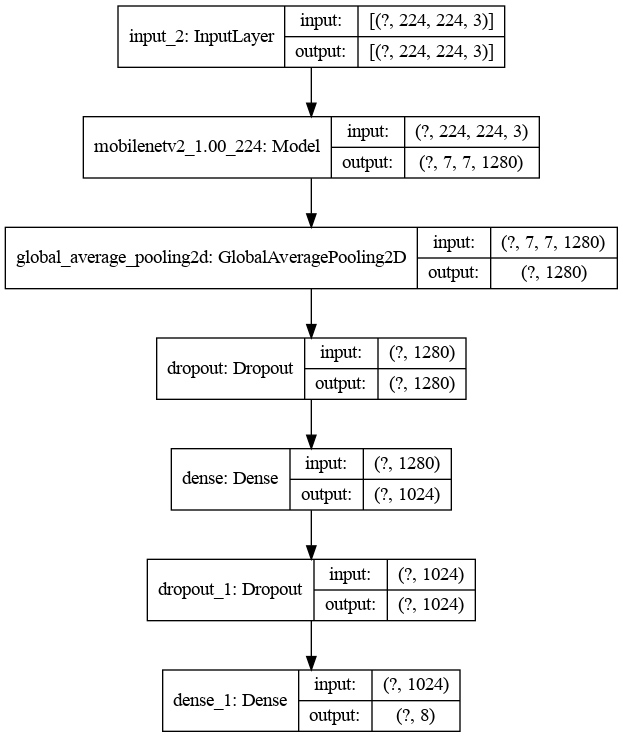

In [13]:
# Case 1
l_rate = 0.00001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate), metrics=['accuracy'])

model.summary()
utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [14]:
# Case 1
n_epoch = 50
history = model.fit(train_generator,
                    epochs=n_epoch, 
                    validation_data = validation_generator, 
                    verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

Epoch 1/50
80/80 [==============================] - 24s 300ms/step - loss: 2.8419 - accuracy: 0.1458 - val_loss: 1.8993 - val_accuracy: 0.2657
Epoch 2/50
80/80 [==============================] - 21s 267ms/step - loss: 2.4624 - accuracy: 0.1881 - val_loss: 1.6948 - val_accuracy: 0.4010
Epoch 3/50
80/80 [==============================] - 22s 270ms/step - loss: 2.2441 - accuracy: 0.2555 - val_loss: 1.5303 - val_accuracy: 0.5072
Epoch 4/50
80/80 [==============================] - 23s 292ms/step - loss: 2.1639 - accuracy: 0.2868 - val_loss: 1.3893 - val_accuracy: 0.5652
Epoch 5/50
80/80 [==============================] - 21s 268ms/step - loss: 1.8822 - accuracy: 0.3292 - val_loss: 1.2672 - val_accuracy: 0.6232
Epoch 6/50
80/80 [==============================] - 23s 285ms/step - loss: 1.8903 - accuracy: 0.3495 - val_loss: 1.1553 - val_accuracy: 0.7005
Epoch 7/50
80/80 [==============================] - 22s 269ms/step - loss: 1.7171 - accuracy: 0.4138 - val_loss: 1.0608 - val_accuracy: 0.7198

KeyboardInterrupt: 

In [ ]:
# Case 1
print("Model evaluate Case 1:")
results = model.evaluate(test_data)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

In [ ]:
test_labels = test_data.classes
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=test_data.num_classes)

preds = np.round(model.predict(test_data),0)

classification_metrics = metrics.classification_report(test_labels, preds, target_names=class_names)
print(classification_metrics)

IndexError: index 8 is out of bounds for axis 0 with size 8

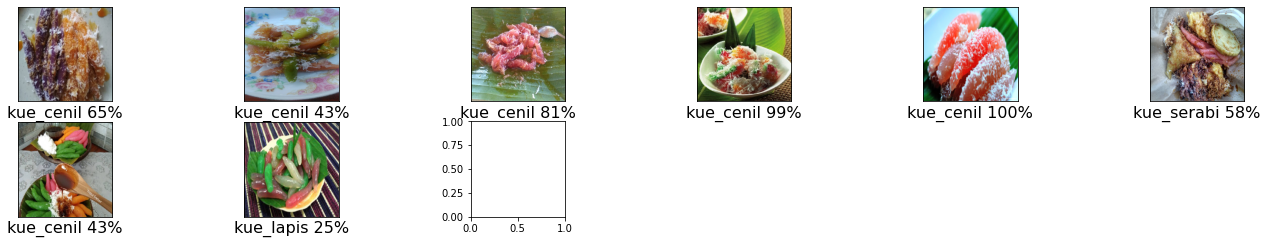

In [28]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


In [ ]:
# Graph Before

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
